## Step 1: Feature Transformation

In [1]:
# Importing Libraries
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# paths 
INP = Path("../data_work/loans_cleaned.parquet")
OUT = Path("../data_work/loans_fe.parquet")
RESULTS = Path("../results"); RESULTS.mkdir(exist_ok=True, parents=True)

In [3]:
# 1) Load cleaned data
df = pd.read_parquet(INP)
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,annual_inc,dti,fico,grade,sub_grade,emp_length,home_ownership,purpose,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,target
0,61548863,2015-10-01,2015-10-01,10000,36,0.0789,312.859985,37000.0,33.669998,705,a,a5,10.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
1,61429137,2015-10-01,2015-10-01,35000,36,0.0818,1099.689941,120000.0,17.580000,730,b,b1,4.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
2,61308389,2015-10-01,2015-10-01,18000,60,0.1099,391.279999,50000.0,22.540001,710,b,b4,5.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
3,60547906,2015-10-01,2015-10-01,9000,36,0.0818,282.779999,75000.0,22.020000,730,b,b1,10.0,mortgage,credit_card,18892.206,5.033333,237.837,0.16,0
4,61308501,2015-10-01,2015-10-01,20575,60,0.1655,506.380005,78000.0,24.139999,700,d,d2,10.0,rent,other,18892.206,5.033333,237.837,0.16,0


In [4]:
# 2) Drop identifiers / leakage
for c in ["id", "issue_d", "sub_grade"]:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


In [5]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'installment',
       'annual_inc', 'dti', 'fico', 'grade', 'emp_length', 'home_ownership',
       'purpose', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target'],
      dtype='object')

In [6]:
# 3) # Keep only one clean DTI column
if "debt_to_income_ratio" in df.columns:
    df.drop(columns=["debt_to_income_ratio"], inplace=True)

# Ensure dtype consistency
df["dti"] = pd.to_numeric(df["dti"], errors="coerce").astype("float32")


In [7]:
# 4) Ensure log income exists (useful + stable)
if "log_annual_inc" not in df.columns and "annual_inc" in df.columns:
    df["log_annual_inc"] = np.log1p(pd.to_numeric(df["annual_inc"], errors="coerce"))
    df.drop(columns=["annual_inc"], inplace=True)

In [8]:
# 5) Minimal numeric NA fill (only if present)
num_cols = df.select_dtypes(include=[np.number]).columns
if df[num_cols].isna().any().any():
    df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))

In [9]:
# 6) One-hot encode compact categoricals (drop_first to avoid dummy trap)
cat_cols = [c for c in ["grade", "home_ownership", "purpose"] if c in df.columns]
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, prefix=cat_cols)

In [10]:
df.head(2)

,issue_q_start,loan_amnt,term_m,int_rate,installment,dti,fico,emp_length,GDPC1,UNRATE,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,2015-10-01,10000,36,0.0789,312.859985,33.669998,705,10.0,18892.206,5.033333,...,False,False,False,False,False,False,False,False,False,False
1,2015-10-01,35000,36,0.0818,1099.689941,17.580000,730,4.0,18892.206,5.033333,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'installment',
       'dti', 'fico', 'emp_length', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS',
       'target', 'log_annual_inc', 'grade_b', 'grade_c', 'grade_d', 'grade_e',
       'grade_f', 'grade_g', 'home_ownership_mortgage', 'home_ownership_none',
       'home_ownership_other', 'home_ownership_own', 'home_ownership_rent',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [12]:
print("Step 1 complete — transformed shape:", df.shape)

Step 1 complete — transformed shape: (2258953, 38)


## 2. Feature Construction

In [13]:
# 1) Macro QoQ deltas (by issue_q_start)
if "issue_q_start" in df.columns:
    df.sort_values(["issue_q_start"], inplace=True)
    for col in ["UNRATE","FEDFUNDS","GDPC1","CPIAUCSL"]:
        if col in df.columns:
            delta_name = f"{col}_delta_qoq"
            qavg = df.groupby("issue_q_start")[col].mean().sort_index().pct_change()
            df = df.merge(qavg.rename(delta_name), left_on="issue_q_start", right_index=True, how="left")

    if "int_rate" in df.columns and "CPIAUCSL_delta_qoq" in df.columns:
        df["inflation_qoq"] = df["CPIAUCSL_delta_qoq"]
        df.drop(columns=['CPIAUCSL_delta_qoq'], inplace=True)
        df["real_rate_qoq"] = df["int_rate"] - df["inflation_qoq"]


In [14]:
# 2) Clean infinities/new NaNs from constructed fields; light fills
for c in ["inflation_qoq","real_rate_qoq",
          "UNRATE_delta_qoq","FEDFUNDS_delta_qoq","GDPC1_delta_qoq","CPIAUCSL_delta_qoq"]:
    if c in df.columns:
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)
        df[c] = df[c].fillna(0.0 if c.endswith("_qoq") else df[c].median())

In [15]:
print("Step 2 complete — constructed shape:", df.shape)


Step 2 complete — constructed shape: (2258953, 43)


## 3. Feature Selection (Statistical: variance + correlation)

In [16]:
# 1) Identify numeric feature columns (exclude target)
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != "target"]


In [17]:
num_cols

['loan_amnt',
 'term_m',
 'int_rate',
 'installment',
 'dti',
 'fico',
 'emp_length',
 'GDPC1',
 'UNRATE',
 'CPIAUCSL',
 'FEDFUNDS',
 'log_annual_inc',
 'UNRATE_delta_qoq',
 'FEDFUNDS_delta_qoq',
 'GDPC1_delta_qoq',
 'inflation_qoq',
 'real_rate_qoq']

In [18]:
df.head()

,issue_q_start,loan_amnt,term_m,int_rate,installment,dti,fico,emp_length,GDPC1,UNRATE,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
1299049,2007-04-01,3500,36,0.1028,113.389999,10.00,685,0.5,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1296307,2007-04-01,7500,36,0.1375,255.429993,14.29,660,0.5,16713.314,4.5,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1299052,2007-04-01,5000,36,0.0775,156.110001,8.81,770,10.0,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1299051,2007-04-01,2525,36,0.0933,80.690002,10.00,710,0.5,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0
1299050,2007-04-01,1000,36,0.0964,32.110001,10.00,695,0.5,16713.314,4.5,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0


In [20]:
# 2) Low-variance / near-constant feature filter (with protection list)
# Columns we never drop here (economically meaningful even if low variance)
protected = {
    "int_rate", "dti", "fico", "log_annual_inc",
    "GDPC1", "UNRATE", "CPIAUCSL", "FEDFUNDS",
    "GDPC1_delta_qoq", "UNRATE_delta_qoq", "CPIAUCSL_delta_qoq",
    "inflation_qoq", "real_rate_qoq"
}

candidate_cols = df.select_dtypes(include=["number", "bool"]).columns

flagged, dropped = [], []

for c in candidate_cols:
    if c in protected:
        continue  # never drop protected features

    nunique = df[c].nunique()
    var = df[c].var()

    # Drop only:
    #  - perfectly constant numerics (nunique <= 1)
    #  - near-constant booleans (very sparse or very dense)
    if nunique <= 1:
        flagged.append((c, "constant"))
        dropped.append(c)
    elif df[c].dtype == "bool":
        p = df[c].mean()  # share of True
        if p < 0.01 or p > 0.99:
            flagged.append((c, f"bool near-constant (p_true={p:.4f})"))
            dropped.append(c)
    # NOTE: We intentionally do NOT drop low-variance continuous numerics here.

if dropped:
    print(f"Dropping {len(dropped)} near-constant features (unprotected):", dropped)
    df.drop(columns=dropped, inplace=True)
else:
    print("No near-constant (unprotected) features found.")

# Optional: show what was flagged and why
if flagged:
    print("Flagged features (reason):")
    for name, reason in flagged:
        print(f"  - {name}: {reason}")

No near-constant (unprotected) features found.


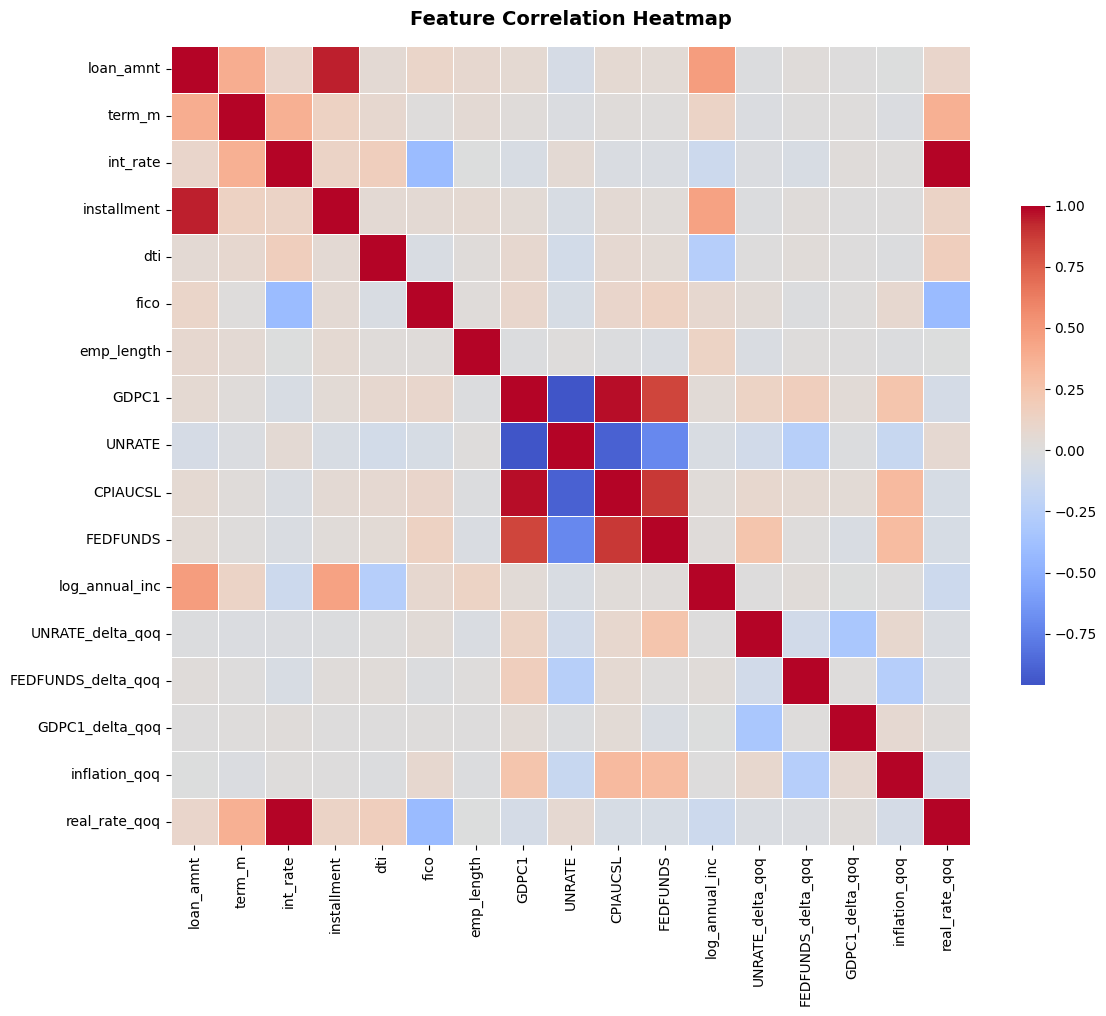

In [21]:
# 3) Heatmap to show correlation of numeric attributes
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()

sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.6},)
plt.title("Feature Correlation Heatmap", fontsize=14, weight="bold", pad=15)
plt.tight_layout()
plt.savefig("../results/figures/feature_correlation_heatmap.png", dpi=300)
plt.show()

In [22]:
# Continuous-only correlation matrix (exclude booleans and target)
num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != "target" and df[c].nunique() > 2]
corr = df[num_cols].corr().abs()

THRESH = 0.85

# 1) Core features you must NEVER drop
never_drop = {
    "log_annual_inc", "loan_amnt", "fico",
    "int_rate", "UNRATE", "GDPC1", "CPIAUCSL", "FEDFUNDS",
    "UNRATE_delta_qoq", "FEDFUNDS_delta_qoq", "GDPC1_delta_qoq",
    "CPIAUCSL_delta_qoq", "inflation_qoq", "real_rate_qoq"
}

# 2) Heuristic preferences (lower score = keep more)
pref_score = {}
def score(name: str) -> int:
    if name in never_drop: return 0
    if name.endswith("_scaled"): return 5
    if name == "installment": return 4
    if name in {"term_m"}: return 3
    return 2  # default

to_drop = set()
checked = set()

for i, a in enumerate(num_cols):
    for j, b in enumerate(num_cols):
        if j <= i: 
            continue
        if (a, b) in checked or (b, a) in checked:
            continue
        checked.add((a, b))
        r = corr.loc[a, b]
        if pd.notna(r) and r > THRESH:
            # If either is never-drop and the other isn't, drop the other
            if a in never_drop and b not in never_drop:
                to_drop.add(b); continue
            if b in never_drop and a not in never_drop:
                to_drop.add(a); continue
            # If both are never-drop, keep both
            if a in never_drop and b in never_drop:
                continue
            # Otherwise, drop the one with worse (higher) score
            to_drop.add(a if score(a) > score(b) else b)

# Final safety: never drop protected, even if accidentally added
to_drop -= never_drop

if to_drop:
    print(f"Dropping {len(to_drop)} highly correlated features (|r|>{THRESH}): {sorted(to_drop)}")
    df.drop(columns=list(to_drop), inplace=True)
else:
    print("No highly correlated features above threshold found.")


Dropping 1 highly correlated features (|r|>0.85): ['installment']


In [23]:
# 4) Print resulting dimensionality
print(f"Step 3 complete — selected features: {df.shape[1]} columns total")

Step 3 complete — selected features: 33 columns total


In [24]:
# To show top correlated remaining pairs for inspection
corr_pairs = (
    corr.stack()
    .reset_index()
    .rename(columns={"level_0":"Feature1","level_1":"Feature2",0:"Correlation"})
)

print("\nTop remaining correlations:")
display(corr_pairs.sort_values(by="Correlation", ascending=False).head(10))



Top remaining correlations:


,Feature1,Feature2,Correlation
0,loan_amnt,loan_amnt,1.0
17,int_rate,int_rate,1.0
238,inflation_qoq,inflation_qoq,1.0
221,GDPC1_delta_qoq,GDPC1_delta_qoq,1.0
204,FEDFUNDS_delta_qoq,FEDFUNDS_delta_qoq,1.0
187,UNRATE_delta_qoq,UNRATE_delta_qoq,1.0
170,log_annual_inc,log_annual_inc,1.0
153,FEDFUNDS,FEDFUNDS,1.0
136,CPIAUCSL,CPIAUCSL,1.0
119,UNRATE,UNRATE,1.0


In [25]:
df.columns

Index(['issue_q_start', 'loan_amnt', 'term_m', 'int_rate', 'dti', 'fico',
       'emp_length', 'GDPC1', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'target',
       'log_annual_inc', 'grade_b', 'grade_c', 'grade_d', 'grade_e', 'grade_f',
       'home_ownership_mortgage', 'home_ownership_own', 'home_ownership_rent',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical',
       'purpose_other', 'purpose_small_business', 'UNRATE_delta_qoq',
       'FEDFUNDS_delta_qoq', 'GDPC1_delta_qoq', 'inflation_qoq',
       'real_rate_qoq'],
      dtype='object')

In [26]:
df.to_parquet(OUT, index=False)

In [27]:
print(f"Final Data Shape: {df.shape}")

Final Data Shape: (2258953, 33)


In [28]:
df.sample(5)

,issue_q_start,loan_amnt,term_m,int_rate,dti,fico,emp_length,GDPC1,UNRATE,CPIAUCSL,...,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,UNRATE_delta_qoq,FEDFUNDS_delta_qoq,GDPC1_delta_qoq,inflation_qoq,real_rate_qoq
1135668,2014-10-01,1500,36,0.0649,17.299999,720,3.0,18500.031,5.700000,236.888333,...,False,False,False,False,False,-0.060440,0.111111,0.005057,-0.002484,0.067384
1473150,2018-04-01,13000,36,0.0683,27.430000,720,1.0,20150.476,3.933333,250.679000,...,False,False,False,False,False,-0.024793,0.200461,0.005308,0.005444,0.062856
1406322,2016-07-01,5000,36,0.1449,23.010000,730,10.0,19197.938,4.900000,240.607333,...,False,False,False,False,False,-0.006757,0.062500,0.007094,0.004245,0.140655
1238034,2018-04-01,25000,60,0.1403,16.389999,705,10.0,20150.476,3.933333,250.679000,...,False,False,False,False,False,-0.024793,0.200461,0.005308,0.005444,0.134856
869151,2014-04-01,10000,36,0.1099,15.710000,685,0.5,18185.911,6.200000,236.872333,...,False,False,False,False,False,-0.070000,0.272727,0.012918,0.005311,0.104589
